In [1]:
pip install Flask

Note: you may need to restart the kernel to use updated packages.


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://localhost:9000/ (Press CTRL+C to quit)
127.0.0.1 - - [12/Oct/2020 19:02:12] "GET /?id=patric%40gmail.com HTTP/1.1" 302 -
127.0.0.1 - - [12/Oct/2020 19:02:20] "GET /?id=patric%40gmail.com HTTP/1.1" 302 -
127.0.0.1 - - [12/Oct/2020 19:02:30] "GET /?id=patric%40gmail.com HTTP/1.1" 302 -
127.0.0.1 - - [12/Oct/2020 19:02:38] "GET /?id=patric%40gmail.com HTTP/1.1" 302 -


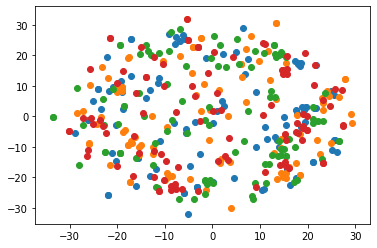

In [1]:
from flask import request , redirect , Flask
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random as rd
import urllib

#차원축소
from sklearn.manifold import MDS

#군집
from sklearn.cluster import KMeans

#군집 시각화
from scipy.spatial.distance import cdist

#위도 경도 거리계산
from haversine import haversine

# DB 연결
import cx_Oracle
import pandas as pd


app = Flask(__name__)
@app.route("/")
def hello():
    z=request.args.get('id')
    z=urllib.parse.unquote("{}".format(z))
    q=z
    z="'{}'".format(z)
    dsn = cx_Oracle.makedsn("phil87.cfxt9kqdcbog.ap-northeast-2.rds.amazonaws.com",1521,"orcl")
    db = cx_Oracle.connect("phil87","phil1234!",dsn)
    cursor = db.cursor()
    cursor.execute("select p_num, p_name, coordinate_x, coordinate_y, mountain, beach, town, exotic, healing, activity, hotspot, beverage, food, history, walkbicycle, drivebike, play, shopping, pet, festival from place WHERE PICK>70 ORDER BY PICK DESC")
    x = cursor.fetchall()
    place_data = pd.DataFrame(x)
    col = ['p_num', 'p_name','coordinate_x','coordinate_y','mountain','beach','town','exotic','healing','activity','hotspot','beverage','food','history','walkbicycle','drivebike','play','shopping','pet','festival']
    place_data.columns=col
    sql = "select m_num, m_name, age, ranks, mountain, beach, town, exotic, healing, activity, hotspot, beverage, food, history, walkbicycle, drivebike, play, shopping, pet, festival from member where m_email={}".format(z)
    cursor1 = db.cursor()
    cursor1.execute(sql)
    x1 = cursor1.fetchall()
    member_data = pd.DataFrame(x1)
    col = ['p_num', 'p_name','coordinate_x','coordinate_y','mountain','beach','town','exotic','healing','activity','hotspot','beverage','food','history','walkbicycle','drivebike','play','shopping','pet','festival']
    member_data.columns = col
    place_data = place_data.iloc[:100,:] #데이터 크기에따라서 행 개수 결정
    tt_data = place_data.append(member_data)
    embedding = MDS(n_components=2)
    tt_transformed = embedding.fit_transform(tt_data.iloc[:, 4:])
    tt_transformed
    plt.scatter(tt_transformed[:,0],tt_transformed[:,1])
    kmeans = KMeans(n_clusters=3) #n개 군집으로 나눈 n_clusters
    kmeans.fit(tt_transformed) # 훈련
    tt_data['grade'] = kmeans.labels_
    grade_list = []
    grade_list_spot =[]

    for i in range(tt_data.shape[0]-1):
        if tt_data.iloc[-1, -1] == tt_data.iloc[i,-1]:
            #뽑는 값 변화
            grade_list.append(tt_data.iloc[i,0])
            grade_list_spot.append(tt_data.iloc[i,2:4])
    sql = "select period from member where m_email = {}".format(z)
    cursor2 = db.cursor()
    cursor2.execute(sql)
    period = cursor2.fetchall()
    period=int(str(period[0]).replace('(','').replace(')','').replace(',','').replace("'",''))

    if period == 0:
        rd_spot1 = rd.sample(grade_list, 3)
        rd_spot_df = pd.DataFrame(rd_spot1)
    if period == 1:
        rd_spot1 = rd.sample(grade_list, 5)
        rd_spot_df = pd.DataFrame(rd_spot1)
    if period == 2:
        rd_spot1 = rd.sample(grade_list, 8)
        rd_spot_df = pd.DataFrame(rd_spot1)
    if period == 3:
        rd_spot1 = rd.sample(grade_list, 11)
        rd_spot_df = pd.DataFrame(rd_spot1)
    if period == 4:
        rd_spot1 = rd.sample(grade_list, 14)
        rd_spot_df = pd.DataFrame(rd_spot1)
    if period == 5:
        rd_spot1 = rd.sample(grade_list, 17)
        rd_spot_df = pd.DataFrame(rd_spot1)

    rd_spot_result = rd_spot_df
        
    recommend_spot = []
    rd_spot_result = rd_spot_df.applymap(str)
    for i in range(rd_spot_df.shape[0]):
        recommend_spot.append(rd_spot_result.iloc[i,:] + '-')
    sql = "update member set suggestion = '' where m_email = {}".format(z)
    cursor3 = db.cursor()
    cursor3.execute(sql)
    db.commit()
    rows=[tuple(x)for x in rd_spot_df.to_records(index=False)]
    cursor4 = db.cursor()
    for i in range(len(rows)):
        k = str(rows[i]).replace(',','').replace('(','').replace(')','') + '-'
        sql = "update member set suggestion = suggestion||:1 where m_email =:2"
        cursor4.execute(sql,(k ,q))
    db.commit()

    
    
    return redirect('http://localhost:8087/newbida/period.jsp')



if __name__ == "__main__":
    app.run(host="localhost",port="9000")